# Spark Data Processing

Environment: Python 3.7, Jupyter notebook, JDK1.8, Ubuntu

Libraries used:
* pyspark (for data processing)
* re (for data wrangling)
* nltk (for filtering stopwords)
* matplotlib (for plot graphs)
* os (for setting environment for mongoDB)
* datetime (for date type)
* matplotlib (for plot graphs)
* numpy (for exponenet function exp())

## Part A: Analysis and Visualization by Spark RDD

## Introduction
In this part, it is aimed to analyse the data in two books, `Agile Processes in Software Engineering and Extreme Programming.txt` and `Scrum Handbook.txt`. 

The goals in the project are: 
1. wrangling data
2. processing to extract data statistics information
3. visualization

## Step 01: Import pyspark and initialize Spark

Import the lilbraries used for this notebook.

If there is some libraries not installed in the computer, please delete the `#` and install it by running the codes below.

In [1]:
#!pip install pyspark==2.4.8
#!pip install nltk
import nltk
nltk.download('stopwords')
#!pip install matplotlib

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/controlnet/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date
import pyspark.sql.functions as F
import re
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from math import log
import os
import numpy as np
from datetime import datetime, timedelta

import warnings
warnings.filterwarnings("ignore")

Initialize the spark application

In [3]:
# If there is an existing spark context, we will reuse it instead of creating a new context.
sc = SparkContext.getOrCreate()

# If there is no existing spark context, we now create a new context by SparkConf
if (sc is None):
    conf = pyspark.SparkConf()
    conf.set("spark.app.name", "Data Processing with Spark")
    conf.set("spark.master", "local[*]")
    sc = SparkContext(conf=conf)

21/10/29 03:26:47 WARN Utils: Your hostname, CNETLINUXSERVER resolves to a loopback address: 127.0.1.1; using 192.168.0.146 instead (on interface enp3s0)
21/10/29 03:26:47 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
21/10/29 03:26:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


## Step 02: Create Resilient Distributed Datasets (RDDs)

The resources is provided from moodle, there are:
1. Book1: "Agile Processes  in Software Engineering  and Extreme Programming.txt"
2. Book2: "Scrum Handbook.txt"

Naming the Book1 related dataset as `agileRdd`, and the `scrumRdd` for Book2.

In [4]:
# read the txt files, and store them in the variables
agileRdd = sc.textFile("Agile Processes  in Software Engineering  and Extreme Programming.txt")
scrumRdd = sc.textFile("Scrum Handbook.txt")
# calculate the length of lines and print
print("The number of lines of Agile Processes is", len(agileRdd.collect()))
print("The number of lines of Scrum Handbook is", len(scrumRdd.collect()))

The number of lines of Agile Processes is 21569
The number of lines of Scrum Handbook is 4617


In [5]:
# check the content of the rdd
agileRdd.take(10)

['LNBIP251 ',
 '',
 '',
 'I Helen Sharp ',
 '',
 'Tracy Hall (Eds.) ',
 '',
 'Agile Processes ',
 'in Software Engineering ',
 'and Extreme Programming ']

## Step 03: Cleaning/Manipulating text

The text should be mannipulated in these steps, and a function contains the functionalities need to be created.

1. Removes all characters which are not alphabets except space(s).
2. Changes all uppercase letters to lowercase.
3. Removes all leading or trailing spaces.

Define a function below to perform these three steps.

In [6]:
def parseLine(line):
    regex = r"[^A-Za-z ]"
    new_line = re.sub(regex, "", line)  # step 1
    new_line = new_line.lower()  # step 2
    new_line = re.sub(r"^ +", "", new_line)  # step 3, remove leading spaces
    new_line = re.sub(r" +$", "", new_line)  # step 3, remove trailing spaces
    return new_line

Then apply the function into the elements of these 2 RDDs, and display the contents of RDDs.

In [7]:
agileParsedRdd = agileRdd.map(parseLine)
agileParsedRdd.take(5)

['lnbip', '', '', 'i helen sharp', '']

In [8]:
scrumParsedRdd = scrumRdd.map(parseLine)
scrumParsedRdd.take(5)

['jeff sutherlands', '', 'scrum handbook', '', '']

## Step 04: Transforming the Data/Counting the words

Then, split each element into words by using `pyspark.RDD.flatMap()`. (pyspark, 2019)

In [10]:
# split each rows to words
agileWordsRdd = agileParsedRdd.flatMap(lambda x: x.split(" ")).filter(lambda x: x!="")
agileWordsRdd.take(5)

['lnbip', 'i', 'helen', 'sharp', 'tracy']

In [11]:
scrumWordsRdd = scrumParsedRdd.flatMap(lambda x: x.split(" ")).filter(lambda x: x!="")
scrumWordsRdd.take(5)

['jeff', 'sutherlands', 'scrum', 'handbook', 'everything']

Then, calculate the amount for each words by using `pyspark.RDD.reduceByKey()`(pyspark, 2019), and sort it.

In [13]:
# firstly, transfer each word into the format of (word, 1);
# secondly, sum the numbers for the same word;
# thirdly, sort it by key.
agileCountRdd = agileWordsRdd.map(lambda x: (x, 1))\
    .reduceByKey(lambda x, y: x + y)\
    .sortBy(lambda x: x[1], ascending=False)
# display the result for top 20 words
agileCountRdd.take(20)

[('the', 8145),
 ('and', 3965),
 ('of', 3944),
 ('to', 3714),
 ('in', 3076),
 ('a', 2701),
 ('is', 1539),
 ('that', 1355),
 ('for', 1194),
 ('as', 1028),
 ('on', 1015),
 ('we', 975),
 ('with', 969),
 ('software', 922),
 ('this', 915),
 ('are', 784),
 ('agile', 748),
 ('it', 741),
 ('development', 737),
 ('was', 711)]

In [14]:
scrumCountRdd = scrumWordsRdd.map(lambda x: (x, 1))\
    .reduceByKey(lambda x, y: x + y)\
    .sortBy(lambda x: x[1], ascending=False)
scrumCountRdd.take(20)

[('the', 1238),
 ('of', 537),
 ('and', 534),
 ('to', 477),
 ('a', 451),
 ('scrum', 395),
 ('in', 360),
 ('is', 348),
 ('team', 260),
 ('product', 232),
 ('for', 195),
 ('that', 181),
 ('it', 165),
 ('on', 149),
 ('sprint', 146),
 ('this', 142),
 ('with', 132),
 ('as', 124),
 ('are', 119),
 ('by', 118)]

Then, display the top 20 most frequent words for each Book.

In [16]:
print("The 20 most frequent words in Book 1 are", agileCountRdd.map(lambda x: x[0]).take(20))
print("")
print("The 20 most frequent words in Book 2 are", scrumCountRdd.map(lambda x: x[0]).take(20))

The 20 most frequent words in Book 1 are ['the', 'and', 'of', 'to', 'in', 'a', 'is', 'that', 'for', 'as', 'on', 'we', 'with', 'software', 'this', 'are', 'agile', 'it', 'development', 'was']

The 20 most frequent words in Book 2 are ['the', 'of', 'and', 'to', 'a', 'scrum', 'in', 'is', 'team', 'product', 'for', 'that', 'it', 'on', 'sprint', 'this', 'with', 'as', 'are', 'by']


## Step 05: Removing Stop Words

Using `nltk` library get stop words set.(Upadhyay, 2019)

In [18]:
# get English stop words from nltk
stopWords = set(stopwords.words("english"))
# filter the words that is not in stop words set
agileCountFixedRdd = agileCountRdd.filter(lambda x: x[0] not in stopWords)
agileCountFixedRdd.take(5)

[('software', 922),
 ('agile', 748),
 ('development', 737),
 ('team', 554),
 ('product', 451)]

In [19]:
scrumCountFixedRdd = scrumCountRdd.filter(lambda x: x[0] not in stopWords)
scrumCountFixedRdd.take(5)

[('scrum', 395),
 ('team', 260),
 ('product', 232),
 ('sprint', 146),
 ('development', 98)]

Then, using the similar method in Step 04 to get pure words sequences for each book.

In [20]:
# count the unique words count in each book
agileUniqueWordsCount = len(agileCountFixedRdd.map(lambda x: x[0]).collect())
scrumUniqueWordsCount = len(scrumCountFixedRdd.map(lambda x: x[0]).collect())
# display the result
print("There is {} unique words in {}".format(agileUniqueWordsCount, "Book 1"))
print("There is {} unique words in {}".format(scrumUniqueWordsCount, "Book 2"))

There is 9611 unique words in Book 1
There is 2936 unique words in Book 2


## Step 06: Find the average occurrence of a word
To find the result that require, it is necessary to calculate the total number of words devided that by the number of unique words.

In [21]:
# get the total words count for each rdd
agileTotalWordsCount = agileCountFixedRdd.map(lambda x: x[1]).sum()
scrumTotalWordsCount = scrumCountFixedRdd.map(lambda x: x[1]).sum()
# display the result
print("The total words in these 2 rdds are {} and {}"\
      .format(agileTotalWordsCount,scrumTotalWordsCount))

The total words in these 2 rdds are 79056 and 10810


In [22]:
# calculate the average occurrence
agileAverageOccurrence = agileTotalWordsCount / agileUniqueWordsCount
scrumAverageOccurrence = scrumTotalWordsCount / scrumUniqueWordsCount
# display the result
for each in (("Book 1", agileAverageOccurrence), ("Book 2", scrumAverageOccurrence)):
    print("The average occurrencce in {} is {:.3f}".format(*each))

The average occurrencce in Book 1 is 8.226
The average occurrencce in Book 2 is 3.682


## Step 7: Exploratory data analysis

In [23]:
# get the occurrence list for each words
agileWordsOccurrence = agileCountFixedRdd.map(lambda x: x[1]).collect()
scrumWordsOccurrence = scrumCountFixedRdd.map(lambda x: x[1]).collect()
# get the list containing words with the same order with the occurrences list
agileWordsList = agileCountFixedRdd.map(lambda x: x[0]).collect()
scrumWordsList = scrumCountFixedRdd.map(lambda x: x[0]).collect()

Plot the output for all words in Book 1 and Book 2 with log scale with `plt.xscale()` and `plt.yscale()`. Using `plt.legend()` to put the legend inside. (matplotlib, 2019)

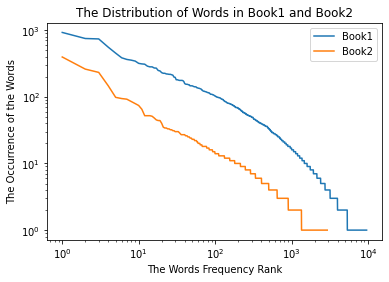

In [24]:
plt.figure()
# plot the trend for Book 1
plt.plot(range(1, len(agileWordsOccurrence)+1), agileWordsOccurrence)
# plot the trend for Book 2
plt.plot(range(1, len(scrumWordsOccurrence)+1), scrumWordsOccurrence)
# other configurations
plt.legend(["Book1", "Book2"])
plt.title("The Distribution of Words in Book1 and Book2")
plt.xlabel("The Words Frequency Rank")
plt.ylabel("The Occurrence of the Words")
plt.xscale("log", basex=10)
plt.yscale("log", basey=10)
plt.show()

From the output, the unique count of words in Book 1 is higher than Book 2. However, the distributions of words from the highest frequency to lowest is similar, because the slope of the curve for Book 1 and Book 2 is similar. It can be considered that the distribution of words is similar in both books.

Plot the output for top 15 most common words in Book 1 and Book 2.

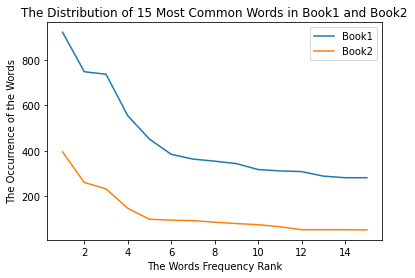

In [25]:
plt.figure()
# plot the trend for Book 1
plt.plot(range(1, 16), agileWordsOccurrence[:15])
# plot the trend for Book 2
plt.plot(range(1, 16), scrumWordsOccurrence[:15])
# other configurations
plt.legend(["Book1", "Book2"])
plt.title("The Distribution of 15 Most Common Words in Book1 and Book2")
plt.xlabel("The Words Frequency Rank")
plt.ylabel("The Occurrence of the Words")
plt.show()

From the output, the distributions of top 15 most common words are similar in Book 1 and Book 2. The shape and the slope of these 2 curves are similar, which can be considered the distributions are also similar.

## Part B: Data Processing by Spark SQL

## Introduction

In part B, it is aimed to analyse the data from a crime data, `Crime_Statistics_SA_2010_present.csv`. 

The goals including will be achieved: 
1. load the data from file
2. processing to data statistics information
3. visualization

## Step 01: Initialize Spark SQL

In [26]:
# If there is an existing spark context, we will reuse it instead of creating a new context.
sc = SparkContext.getOrCreate()

# If there is no existing spark context, we now create a new context by SparkConf
spark = SparkSession(sparkContext=sc)\
    .builder\
    .appName("SparkSQL")\
    .getOrCreate()

## Step 02: Create Dataframe

Create the DataFrame from the csv file, using the `inferSchema=True` to enable the inferSchema functionality. (zero323, 2019)

In [27]:
# read the data from csv file into DataFrame
dataDf = spark.read.csv("Crime_Statistics_SA_2010_present.csv", header=True, inferSchema=True)
# display the number of rows in the DataFrame
print("The number of records in the data frame is", dataDf.count())

The number of records in the data frame is 727408


## Step 03: Read from Database

Using `pyspark.sql.Column.isNotNull()` to drop null data rows. (pyspark, 2019)

In [28]:
df = dataDf
# drop null data rows
df = df.filter(df["Reported Date"].isNotNull())
# display the schema
df.printSchema()

root
 |-- Reported Date: string (nullable = true)
 |-- Suburb - Incident: string (nullable = true)
 |-- Postcode - Incident: string (nullable = true)
 |-- Offence Level 1 Description: string (nullable = true)
 |-- Offence Level 2 Description: string (nullable = true)
 |-- Offence Level 3 Description: string (nullable = true)
 |-- Offence Count: integer (nullable = true)



## Step 04: Calculate the statistics of numeric and string columns

In [29]:
# use SQL to aggregate by "Offence Date"
# and calculate the mean, sd, max and min for offence count
def toStat(dfInput):
    dfInput.createOrReplaceTempView("dfInput")
    dfInputStat = spark.sql("""
        SELECT `Reported Date` AS date,
               SUM(`Offence Count`) AS count,
               ROUND(mean(`Offence Count`),3) AS mean,
               ROUND(stddev(`Offence Count`),3) AS sd,
               ROUND(max(`Offence Count`),3) AS max,
               ROUND(min(`Offence Count`),3) AS min
        FROM dfInput
        GROUP BY date
        ORDER BY date
    """)
    return dfInputStat

# apply the function to df to get statistic data
dfStat = toStat(df)
dfStat.show(5)

[Stage 78:>                                                         (0 + 8) / 8]

+---------+-----+-----+-----+---+---+
|     date|count| mean|   sd|max|min|
+---------+-----+-----+-----+---+---+
|1/01/2011|  408|1.283|0.885|  9|  1|
|1/01/2012|  373|1.203|0.509|  5|  1|
|1/01/2013|  385|1.242|0.708|  6|  1|
|1/01/2014|  384|1.289|0.727|  8|  1|
|1/01/2015|  344|1.313|0.964| 11|  1|
+---------+-----+-----+-----+---+---+
only showing top 5 rows



Then, examine the max and min value for "Reported Date"

In [30]:
# define the function for print the max and min value for date
def printDateExtreme(dfInput):
    date_min = dfInput.select("date").collect()[0][0]
    date_max = dfInput.select("date").collect()[-1][0]
    print("The min value of date is {}.\nThe max value of date is {}"\
          .format(date_min, date_max))
    
printDateExtreme(dfStat)

The min value of date is 1/01/2011.
The max value of date is 9/12/2018


The result of max and min value of date is not correct, bacause the type of date is string, it will be sorted by the characters in the string from first to last. As the location of the number of the day is in the left of month, the program will sort the date by day first and then the month, which is not correct.

## Step 05: Change the date type for a column

This step should be applied with UDF with `pyspark.sql.functions.udf()`. (databricks, 2019)

In [31]:
# define a function to convert the type of string to date
def stringToDate(string):
    date = datetime.strptime(string, "%d/%m/%Y")
    return date

# register the function into spark as UDF
stringToDateUDF = F.udf(stringToDate, pyspark.sql.types.DateType())

# define a function that convert the elements of whole date column into Date type
def changeDateType(dfInput, dateColumnName):
    dfOutput = dfInput.withColumn(dateColumnName, stringToDateUDF(dfInput[dateColumnName]))
    return dfOutput

# apply the function and display the result
dfFixed = changeDateType(df, "Reported Date")
dfFixed.printSchema()

root
 |-- Reported Date: date (nullable = true)
 |-- Suburb - Incident: string (nullable = true)
 |-- Postcode - Incident: string (nullable = true)
 |-- Offence Level 1 Description: string (nullable = true)
 |-- Offence Level 2 Description: string (nullable = true)
 |-- Offence Level 3 Description: string (nullable = true)
 |-- Offence Count: integer (nullable = true)



In [32]:
# display the max and min value of date after transfering the type
dfStatFixed = toStat(dfFixed)
printDateExtreme(dfStatFixed)

The min value of date is 2010-07-01.
The max value of date is 2019-03-31


From the output, the result is correct after comparing with the data in the raw csv file.

## Step 06: Preliminary data analysis 

There are several sub-steps for this step 07.

####  - How many level 2 offences are there?

In [33]:
# group the data by the "level 2 description",
# count the number of "level 2 description",
# extract the number by select() and collect()
dfGroupbyLevel2 = df.groupby("Offence Level 2 Description")\
    .count()\
    .select("Offence Level 2 Description")\
    .collect()
# transfer the column to a Python list
level2List = [each[0] for each in dfGroupbyLevel2]
# display the result
print("The number of level 2 offences is {}.".format(len(level2List)))
print(level2List)

The number of level 2 offences is 9.
['ROBBERY AND RELATED OFFENCES', 'PROPERTY DAMAGE AND ENVIRONMENTAL', 'SEXUAL ASSAULT AND RELATED OFFENCES', 'HOMICIDE AND RELATED OFFENCES', 'ACTS INTENDED TO CAUSE INJURY', 'SERIOUS CRIMINAL TRESPASS', 'OTHER OFFENCES AGAINST THE PERSON', 'FRAUD DECEPTION AND RELATED OFFENCES', 'THEFT AND RELATED OFFENCES']


#### - What is the number of offences against the person?

In [34]:
# group the dataset by "Offence Level 1" to classify the offences against property and person
dfGroupbyLevel1 = df.groupby("Offence Level 1 Description")\
    .sum("Offence Count")

# filter the "Offences against the person" to show the result
dfGroupbyLevel1\
    .filter(
        dfGroupbyLevel1["Offence Level 1 Description"]=="OFFENCES AGAINST THE PERSON"
    ).show()

+---------------------------+------------------+
|Offence Level 1 Description|sum(Offence Count)|
+---------------------------+------------------+
|       OFFENCES AGAINST ...|            175644|
+---------------------------+------------------+



#### - How many serious criminal tresspasses with more than 1 offence count?

In [35]:
# filter the rows which are "SERIOUS CRIMINAL TRESPASS",
# filter the "Offence Count" more than 1,
# sum the "Offence Count" to get the result
df.filter(df["Offence Level 2 Description"] == "SERIOUS CRIMINAL TRESPASS")\
    .filter(df["Offence Count"] > 1)\
    .select("Offence Level 2 Description", "Offence Count")\
    .groupby("Offence Level 2 Description")\
    .sum("Offence Count").show()

+---------------------------+------------------+
|Offence Level 2 Description|sum(Offence Count)|
+---------------------------+------------------+
|       SERIOUS CRIMINAL ...|             18806|
+---------------------------+------------------+



#### - What percentage of crimes are offences against the property?

In [36]:
# using the data frame in previous that group by Level 1
dfGroupbyLevel1.show()

+---------------------------+------------------+
|Offence Level 1 Description|sum(Offence Count)|
+---------------------------+------------------+
|       OFFENCES AGAINST ...|            175644|
|       OFFENCES AGAINST ...|            676526|
+---------------------------+------------------+



In [37]:
# extract the value and caluclate the percentage
# for crimes against the person
personCount = dfGroupbyLevel1.filter(
    dfGroupbyLevel1["Offence Level 1 Description"] == "OFFENCES AGAINST THE PERSON")\
    .select("sum(Offence Count)")\
    .collect()[0][0]
# for crimes against the property
propertyCount = dfGroupbyLevel1.filter(
    dfGroupbyLevel1["Offence Level 1 Description"] == "OFFENCES AGAINST PROPERTY")\
    .select("sum(Offence Count)")\
    .collect()[0][0]

# calculate the percentage and display
propertyPercentage = propertyCount / (personCount + propertyCount)
print("The percentage of offences against property is {}%"
      .format(round(propertyPercentage*100, 2)))

The percentage of offences against property is 79.39%


## Step 07: Exploratory data analysis

#### -  Find the number of crimes per year.
Prepare the data that used for plot.

In [38]:
# make the dates displayed as years,
# group the data by "Year" to get the sum of the number of crimes,
# sort the result by "Year"
dfGroupbyYear = dfFixed\
    .select(F.date_format("Reported Date", "yyyy").alias("Year"), "Offence Count")\
    .groupby("Year")\
    .sum("Offence Count")\
    .withColumnRenamed("sum(Offence Count)", "Count")\
    .sort(F.asc("Year"))
# display the result
dfGroupbyYear.show()

[Stage 136:==========================================>              (6 + 2) / 8]

+----+------+
|Year| Count|
+----+------+
|2010| 61402|
|2011|122204|
|2012|112962|
|2013|106782|
|2014|101750|
|2015|105656|
|2016|107593|
|2017| 50159|
|2018| 55758|
|2019| 27904|
+----+------+



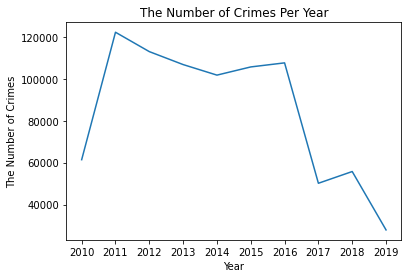

In [39]:
# define a function used for transfer the column to a Python list
def extractColumn(dataFrame, column):
    return [row[column] for row in dataFrame.collect()]

# get the year and the crimes count for each year
yearList = extractColumn(dfGroupbyYear, "Year")
yearCountList = extractColumn(dfGroupbyYear, "Count")

# plot
plt.figure()
plt.plot(yearList, yearCountList)
# other configurations
plt.title("The Number of Crimes Per Year")
plt.xlabel("Year")
plt.ylabel("The Number of Crimes")
plt.show()

The numbers of crimes in 2010, 2017, 2018 and 2019 are very low compare with others, which is strange. That is because, the dataset contains the data from 01/07/2010, so for 2010, there is only 6 months are included, which is lower than 12 months. Also, the data between 01/07/2017 to 30/06/2018 is lost, causing the value in 2017 and 2019 is low than others. Besides, 2019 also only contains the data from 01/01/2019 to 31/03/2019, which causes the similar result that makes the value of 2019 is lower than it should be.

#### - Find the number of crimes per month.

In [40]:
# make the dates displayed as yyyy/MM,
# group the data by "Month" to get the sum of the number of crimes,
# sort the result by "Month"
dfGroupbyMonth = dfFixed\
    .select(F.date_format("Reported Date", "MM").alias("Month"), "Offence Count")\
    .groupby("Month")\
    .sum("Offence Count")\
    .withColumnRenamed("sum(Offence Count)", "Count")\
    .sort(F.asc("Month"))
# display the result
dfGroupbyMonth.show()

[Stage 146:>                                                        (0 + 8) / 8]

+-----+-----+
|Month|Count|
+-----+-----+
|   01|77516|
|   02|70429|
|   03|74931|
|   04|60037|
|   05|64246|
|   06|60687|
|   07|70954|
|   08|72839|
|   09|72595|
|   10|77153|
|   11|75191|
|   12|75592|
+-----+-----+



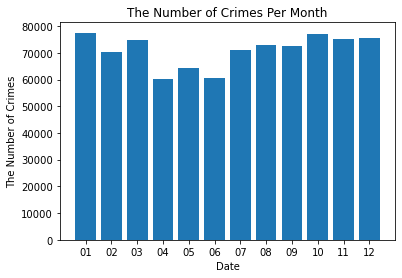

In [41]:
# get the year and the crimes count for each year
monthList = extractColumn(dfGroupbyMonth, "Month")
monthCountList = extractColumn(dfGroupbyMonth, "Count")

# plot
plt.figure()
plt.bar(monthList, monthCountList)
# other configurations
plt.title("The Number of Crimes Per Month")
plt.xlabel("Date")
plt.ylabel("The Number of Crimes")
plt.show()

From the output, most months except April, May and June have similar crimes frequency. The highest one is January, which reach the maximum at 77516, and the lowest one is April, where the number of crimes is 60037. 

#### - Where do most crimes take place?

In [42]:
# define a function to merge the suburb name and post code
# this syntax only is available after Python 3.6 (Python, 2019)
# def joinSuburbName(suburb, postCode):
def joinSuburbName(suburb: str, postCode: str) -> str:
    return suburb + "-" + postCode

# register the function as UDF 
joinSuburbNameUDF = F.udf(joinSuburbName, pyspark.sql.types.StringType())

In [43]:
# firstly, filter the null value from the dataset,
# secondly, join the name of suburb and postcode,
# thirdly, group by suburb to get the sum of offence count for each suburb
dfGroupbySuburb = dfFixed\
    .filter(dfFixed["Postcode - Incident"].isNotNull())\
    .filter(dfFixed["Suburb - Incident"].isNotNull())\
    .withColumn("SuburbPostCode", joinSuburbNameUDF(dfFixed["Suburb - Incident"],
                                                    dfFixed["Postcode - Incident"]))\
    .select("SuburbPostCode", "Offence Count")\
    .groupby("SuburbPostCode")\
    .sum("Offence Count")\
    .sort(F.desc("sum(Offence Count)"))

# display the result
dfGroupbySuburb.show(20)

[Stage 156:=======>                                                 (1 + 7) / 8]

+--------------------+------------------+
|      SuburbPostCode|sum(Offence Count)|
+--------------------+------------------+
|       ADELAIDE-5000|             46701|
|   PORT AUGUSTA-5700|             13711|
|  MOUNT GAMBIER-5290|             13709|
|  MURRAY BRIDGE-5253|             12919|
|  MORPHETT VALE-5162|             12569|
|      SALISBURY-5108|             10806|
|   PORT LINCOLN-5606|             10779|
|      ELIZABETH-5112|             10731|
|NOT DISCLOSED-NOT...|              9375|
|   DAVOREN PARK-5113|              8082|
|PARAFIELD GARDENS...|              8040|
|  OAKLANDS PARK-5046|              7792|
|      PARALOWIE-5108|              7261|
|       PROSPECT-5082|              7234|
|     PORT PIRIE-5540|              7155|
|        MODBURY-5092|              7041|
|     SMITHFIELD-5114|              7000|
|SALISBURY NORTH-5108|              6538|
| WHYALLA STUART-5608|              6297|
|   MAWSON LAKES-5095|              6103|
+--------------------+------------

From the output, there are some strange in the plot.
1. The value of "ADELAIDE" is too high. After investigation, the "ADELAIDE" is a city rather than a suburb, so it should be deleted.
2. There is a suburb named "NOT DISCLOSED" which is meaningless in the plot, so it should be deleted.

Then, plot a bar chart to visualize the data.

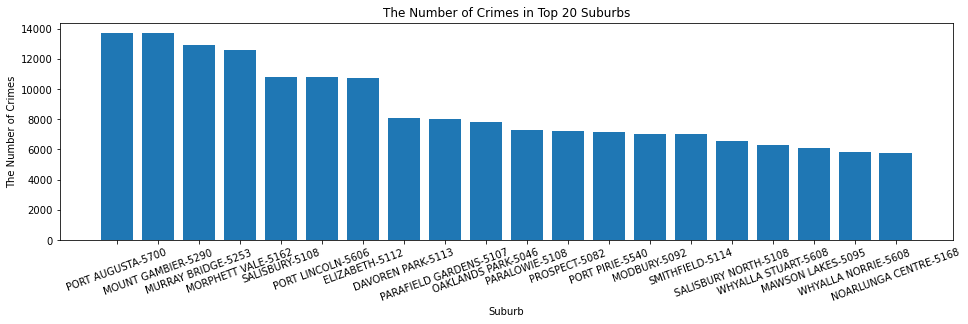

In [44]:
# filter the rows which are not "ADELAIDE" and "NOT DISCLOSED"
dfGroupbySuburbFixed = dfGroupbySuburb\
    .filter(dfGroupbySuburb["SuburbPostCode"] != "ADELAIDE-5000")\
    .filter(dfGroupbySuburb["SuburbPostCode"] != "NOT DISCLOSED-NOT DISCLOSED")

# get the list of top 20 suburbs with most crimes
suburbList = extractColumn(dfGroupbySuburbFixed, "SuburbPostCode")[:20]
suburbCountList = extractColumn(dfGroupbySuburbFixed, "sum(Offence Count)")[:20]
# get a position array for x-axis
suburbPosition = np.arange(len(suburbList))

# plot
plt.figure(figsize=(16,4))
plt.bar(suburbPosition, suburbCountList)
plt.xticks(suburbPosition, suburbList, rotation=20)
# other configurations
plt.title("The Number of Crimes in Top 20 Suburbs")
plt.xlabel("Suburb")
plt.ylabel("The Number of Crimes")
plt.show()

From the output after fixing the error data, the suburb with highest number of crimes is PORT AUGUSTA, and the second one, MOUNT GAMBIER has similar level with the previous one, about 13700. The suburb which ranked 15, NOARLUNGA CENTRE, only has about 6000 crimes in the dataset, which is about half of the highest suburb.

#### - Find the number of serious criminal trespasses by day and month.

In [45]:
# record the serious criminal trespasses as SCT
# filter the rows which are "SERIOUS CRIMINAL TRESPASS"
dfSCT = dfFixed.filter(dfFixed["Offence Level 2 Description"] == "SERIOUS CRIMINAL TRESPASS")
# group the data by day, and count the number of crimes
dfSCTGroupbyDay = dfSCT\
    .select(F.date_format("Reported Date", "u").alias("DayNum"), 
            F.date_format("Reported Date", "E").alias("Day"), 
            "Offence Count")\
    .groupby("DayNum", "Day")\
    .sum("Offence Count")\
    .sort(F.asc("DayNum"))
# group the data by month, and count the number of crimes
dfSCTGroupbyMonth = dfSCT\
    .select(F.date_format("Reported Date", "MM").alias("Month"), "Offence Count")\
    .groupby("Month")\
    .sum("Offence Count")\
    .sort(F.asc("Month"))

# display the result
dfSCTGroupbyDay.show()
dfSCTGroupbyMonth.show()

+------+---+------------------+
|DayNum|Day|sum(Offence Count)|
+------+---+------------------+
|     1|Mon|             20050|
|     2|Tue|             17148|
|     3|Wed|             16203|
|     4|Thu|             15978|
|     5|Fri|             16821|
|     6|Sat|             14065|
|     7|Sun|             14914|
+------+---+------------------+

+-----+------------------+
|Month|sum(Offence Count)|
+-----+------------------+
|   01|             10407|
|   02|              9259|
|   03|              9845|
|   04|              8147|
|   05|              8842|
|   06|              8257|
|   07|              9766|
|   08|              9823|
|   09|             10112|
|   10|             10804|
|   11|             10077|
|   12|              9840|
+-----+------------------+



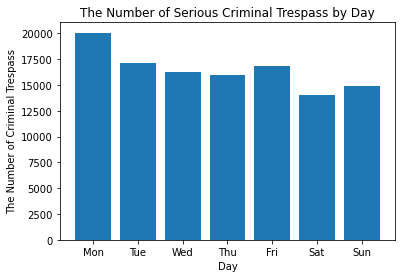

In [46]:
# get the lists of days and the number of crimes for each days
countByDay = extractColumn(dfSCTGroupbyDay, "sum(Offence Count)")
dayList = extractColumn(dfSCTGroupbyDay, "Day")
dayPosition = extractColumn(dfSCTGroupbyDay, "DayNum")

# plot
plt.figure()
plt.bar(dayPosition, countByDay)
plt.xticks(dayPosition, dayList)
# other configurations
plt.title("The Number of Serious Criminal Trespass by Day")
plt.xlabel("Day")
plt.ylabel("The Number of Criminal Trespass")
plt.show()

From the output, Monday is the day has highest number of serious criminal trespass, reaching 20050, and the Saturday is the lowest one, accounting for 14065. The two lowest day is Saturday and Sunday, which means the crimes more happens in weekdays.

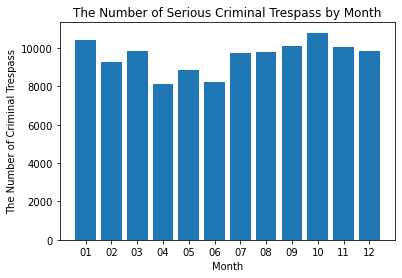

In [47]:
# get the lists of months and the number of crimes for each months
countByMonth = extractColumn(dfSCTGroupbyMonth, "sum(Offence Count)")
monthList = extractColumn(dfSCTGroupbyMonth, "Month")

# plot
plt.figure()
plt.bar(monthList, countByMonth)
# other configurations
plt.title("The Number of Serious Criminal Trespass by Month")
plt.xlabel("Month")
plt.ylabel("The Number of Criminal Trespass")
plt.show()

From the output, the April has the lowest number of serious criminal trespass, which is about 8147, and the October is the highest one, accounting for 10804. 

## Reference
1. databricks. (2019). User-Defined Functions - Python — Databricks Documentation. Retrieved 4 September 2019, from https://docs.databricks.com/spark/latest/spark-sql/udf-python.html
2. pyspark. (2019). pyspark.sql module — PySpark 2.1.0 documentation. Retrieved 4 September 2019, from https://spark.apache.org/docs/2.1.0/api/python/pyspark.sql.html
3. Python. (2019). PEP 3107 -- Function Annotations. Retrieved 4 September 2019, from https://www.python.org/dev/peps/pep-3107/
4. zero323. (2019). inferSchema in spark-csv package. Retrieved 4 September 2019, from https://stackoverflow.com/questions/31719575/inferschema-in-spark-csv-package
5. matplotlib. (2019). matplotlib.pyplot.legend — Matplotlib 3.1.1 documentation. Retrieved 4 September 2019, from https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.legend.html
6. matplotlib. (2019). matplotlib.pyplot.yscale — Matplotlib 3.1.1 documentation. Retrieved 4 September 2019, from https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.yscale.html
7. pyspark. (2019). pyspark package — PySpark 2.2.1 documentation. Retrieved 1 September 2019, from https://spark.apache.org/docs/2.2.1/api/python/pyspark.html?highlight=flatmap#pyspark.RDD.flatMap
8. pyspark. (2019). pyspark package — PySpark 2.4.4 documentation. Retrieved 4 September 2019, from https://spark.apache.org/docs/latest/api/python/pyspark.html?highlight=reducebykey
9. Upadhyay, P. (2019). Removing stop words with NLTK in Python - GeeksforGeeks. Retrieved 4 September 2019, from https://www.geeksforgeeks.org/removing-stop-words-nltk-python/